# Seminar 1

In [ ]:
!if [ -d deepul ]; then rm -Rf deepul; fi
!git clone https://github.com/rll/deepul.git 
!unzip -qq deepul/homeworks/hw1/data/hw1_data.zip -d deepul/homeworks/hw1/data/
!pip install ./deepul

Cloning into 'deepul'...
remote: Enumerating objects: 758, done.
remote: Total 758 (delta 0), reused 0 (delta 0), pack-reused 758
Receiving objects: 100% (758/758), 118.40 MiB | 28.21 MiB/s, done.
Resolving deltas: 100% (347/347), done.
Checking out files: 100% (129/129), done.
Processing ./deepul
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for deepul: filename=deepul-0.1.0-py3-none-any.whl size=16662 sha256=6b8a5ab3f6717723b7575e460993b52f546f975e1884e496a124716b35379d81
  Stored in directory: /tmp/pip-ephem-wheel-cache-7_nillyg/wheels/40/86/14/ae5eebf191515af53ab86be6749af0ae2a71269b38f187557d
Successfully built deepul


In [ ]:
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/6/66/Logisticpdfunction.svg/900px-Logisticpdfunction.svg.png
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/1/1a/Logistic_cdf.svg/2560px-Logistic_cdf.svg.png
!mv 2560px-Logistic_cdf.svg.png logistic_cdf.png
!mv 900px-Logisticpdfunction.svg.png logistic_pdf.png

In [ ]:
from deepul.hw1_helper import *

In [ ]:
import torch
import torch.nn as nn
import torch.optim as opt
import torch.utils.data
import torch.nn.functional as F

from PIL import Image
import numpy as np

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [96]:
plt.rcParams["axes.labelsize"] = 25.
plt.rcParams["xtick.labelsize"] = 20.
plt.rcParams["ytick.labelsize"] = 20.
plt.rcParams["legend.fontsize"] = 18.

plt.rcParams["figure.figsize"] = [8., 6.]

# Question 1: 1D Data

In this question, we will train simple generative models on discrete 1D data.

Execute the cell below to visualize our datasets

Dataset 1


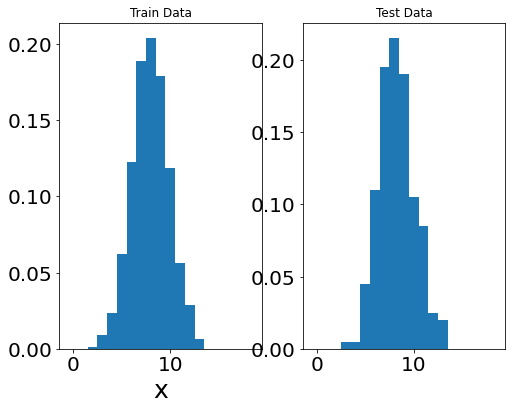

Dataset 2


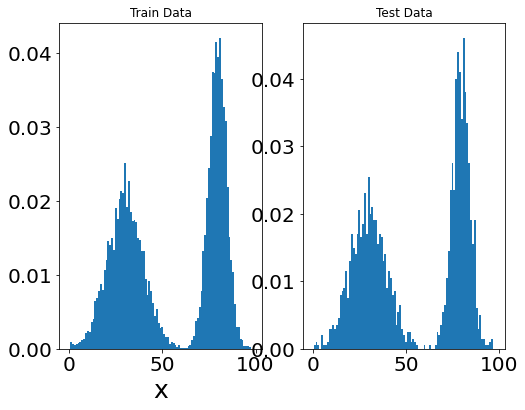

In [97]:
visualize_q1_data(dset_type=1)
visualize_q1_data(dset_type=2)

## Part (a) Fitting a Histogram

Let $\theta = (\theta_0, \dots, \theta_{d-1}) \in \mathbb{R}^d$ and define the model $p_\theta(x) = \frac{e^{\theta_x}}{\sum_{x'}e^{\theta_{x'}}}$

Fit $p_\theta$ with maximum likelihood via stochastic gradient descent on the training set, using $\theta$ initialized to zero. Use your favorite version of stochastic gradient descent, and optimize your hyperparameters on a validation set of your choice.

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. Plot the model probabilities in a bar graph with $\{0,\dots,d-1\}$ on the x-axis and a real number in $[0,1]$ on the y-axis.




### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [46]:
class Histogram(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.d = d
    
    def nll(self, batch):
        raise NotImplementedError()
    
    def probs(self):
        raise NotImplementedError()

    def test(self, data_loader):
        loss = 0
        den = 0
        for batch in data_loader:
            batch.to(device)
            batch_loss = self.nll(batch) * batch.shape[0]
            loss += batch_loss.cpu().detach().item()
            den += batch.shape[0]

        return loss / den

    def fit(self,
            train_data,
            test_data,
            num_epochs=10,
            batch_size=32,
            lr=1e-3):
        
        train_loader = torch.utils.data.DataLoader(train_data, 
                                                   batch_size=batch_size,
                                                   shuffle=True)
        
        test_loader = torch.utils.data.DataLoader(train_data, 
                                                  batch_size=batch_size)
        
        optim = opt.Adam(self.parameters(), lr)
        train_nll = []
        test_nll = []


        self.to(device)
        for epoch in range(num_epochs):
            for batch in train_loader:
                batch = batch.to(device)

                loss = self.nll(batch)

                optim.zero_grad()
                loss.backward()
                optim.step()

                train_nll.append(loss.detach().cpu().item())
            
            test_loss = self.test(test_loader)
            test_nll.append(test_loss)

        return train_nll, test_nll

In [45]:
class HistogramA(Histogram):
    def __init__(self, d):
        super().__init__(d)
        self.theta = nn.Parameter(torch.zeros(1, d), requires_grad=True)
    
    def nll(self, batch):
        return F.cross_entropy(self.theta.repeat(batch.shape[0], 1), batch)
    
    def probs(self):
        return F.softmax(self.theta.squeeze(), dim=0).cpu().detach().numpy()

$CrossEntropy(x, y) = -LogLikelihood(SoftMax(x), y) = \frac 1 {n}\sum\limits_{i=1}^{n} -\left(\log e^{x_{y_i}} - \log \sum e^{x_j}\right)$

In [94]:
def q1_a(train_data, test_data, d, dset_id):
    """
    train_data: An (n_train,) numpy array of integers in {0, ..., d-1}
    test_data: An (n_test,) numpy array of integers in {0, .., d-1}
    d: The number of possible discrete values for random variable x
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
                used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (d,) of model probabilities
    """
    model = HistogramA(d)
    train_loss, test_loss = model.fit(train_data, test_data, num_epochs=20, lr=1e-1, batch_size=100)
    probs = model.probs()
    return train_loss, test_loss, probs


### Results

Once you've implemented `q1_a`, execute the cells below to visualize and save your results



Final Test Loss: 2.0697


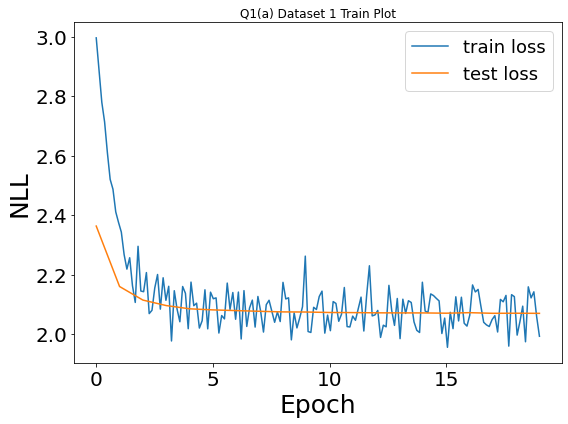

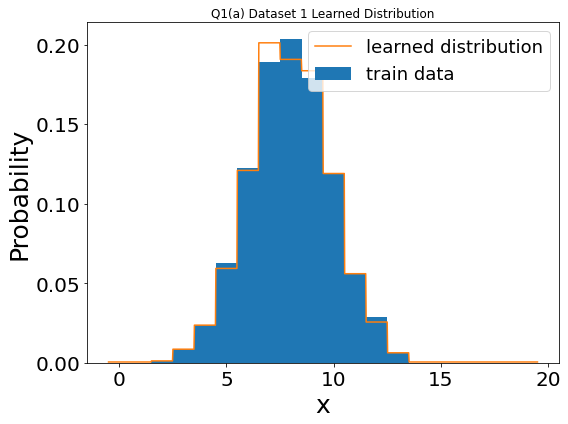

In [98]:
q1_save_results(1, 'a', q1_a)

Final Test Loss: 4.0510


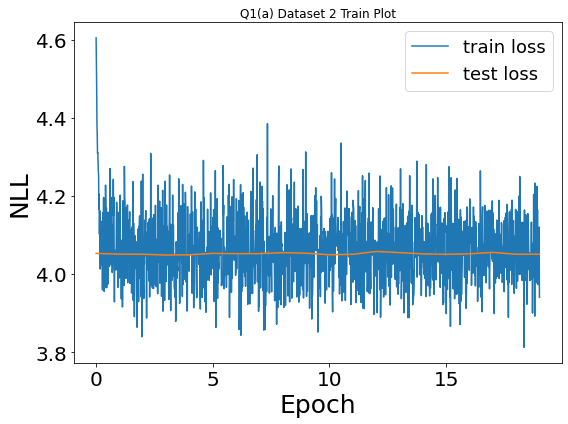

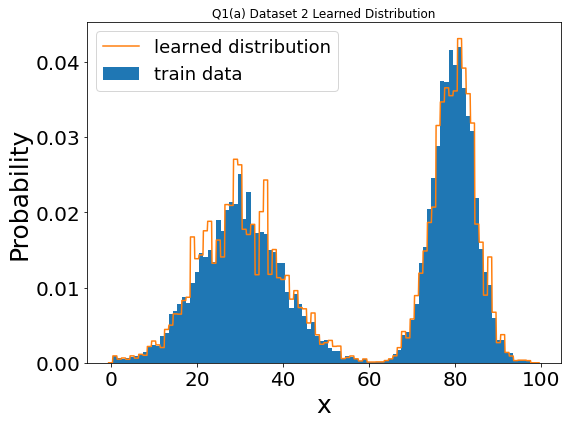

In [99]:
q1_save_results(2, 'a', q1_a)

## Part (b) Fitting Discretized Mixture of Logistics

Let us model $p_\theta(x)$ as a **discretized** mixture of 4 logistics such that $p_\theta(x) = \sum_{i=1}^4 \pi_i[\sigma((x+0.5 - \mu_i)/s_i) - \sigma((x-0.5-\mu_i)/s_i)]$

For the edge case of when $x = 0$, we replace $x-0.5$ by $-\infty$, and for $x = d-1$, we replace $x+0.5$ by $\infty$.

You may find the [PixelCNN++](https://arxiv.org/abs/1701.05517) helpful for more information on discretized mixture of logistics.

**Provide the same set of corresponding deliverables as part (a)**

In [ ]:
logistic_pdf = Image.open('logistic_pdf.png')
logistic_cdf = Image.open('logistic_cdf.png')

In [ ]:
im1 = logistic_pdf.resize((600, 500))
im2 = logistic_cdf.resize((600, 500))

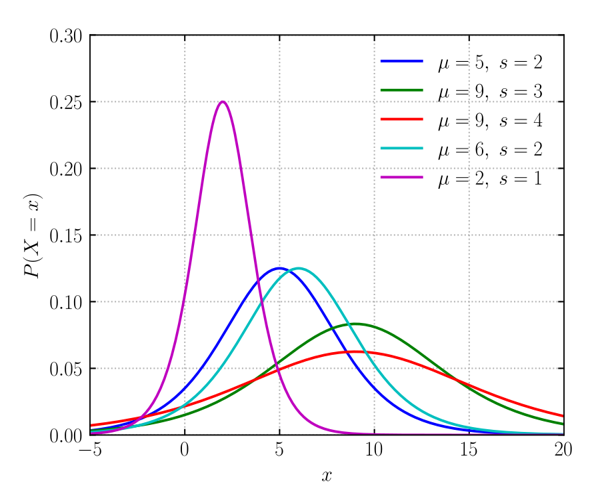

In [100]:
im1

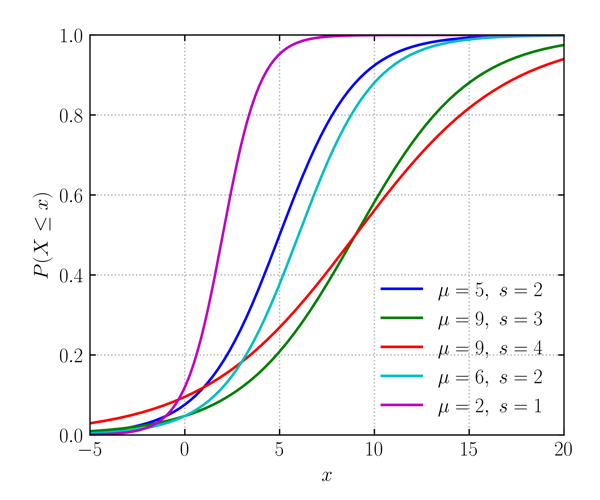

In [ ]:
im2

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [72]:
class HistogramB(Histogram):
    def __init__(self, d, k=4):
        super().__init__(d)
        self.pi_logits = nn.Parameter(torch.zeros(k), requires_grad=True)
        self.mu = nn.Parameter(torch.rand(k).float() * d, requires_grad=True)
        self.log_s = nn.Parameter(torch.zeros(k), requires_grad=True)
        self.k = k

    def nll(self, batch, loss=True):
        x = batch.float().unsqueeze(1).repeat(1, self.k)

        pos = torch.sigmoid((x + 0.5 - self.mu) / self.log_s.exp())
        neg = torch.sigmoid((x - 0.5 - self.mu) / self.log_s.exp())


        pos = torch.where(x == self.d - 1, torch.ones_like(pos), pos)
        neg = torch.where(x == 0, torch.zeros_like(neg), neg)
        
        dif = pos - neg
        dif = torch.clamp(dif, min=1e-16)
        log_dif = dif.log()
        log_prob = log_dif + F.log_softmax(self.pi_logits, dim=0)

        if loss:
            ret = -torch.logsumexp(log_prob, dim=1).mean()
        else:
            ret = log_prob
        
        return ret
    
    def single_prob(self, i):
        x = torch.arange(self.d)
        probs = self.nll(x, loss=False)
        probs = probs[:, i]
        return probs.exp().cpu().detach().numpy()

    def probs(self):
        x = torch.arange(self.d)
        probs = self.nll(x, loss=False)
        probs = torch.logsumexp(probs, dim=1)
        return probs.exp().cpu().detach().numpy()

In [115]:
def q1_b(train_data, test_data, d, dset_id):
    """
    train_data: An (n_train,) numpy array of integers in {0, ..., d-1}
    test_data: An (n_test,) numpy array of integers in {0, .., d-1}
    d: The number of possible discrete values for random variable x
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
            used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (d,) of model probabilities
    """

    model = HistogramB(d, k=4)
    train_loss, test_loss = model.fit(train_data, test_data, num_epochs=30, lr=1e-1, batch_size=100)
    probs = model.probs()
    return train_loss, test_loss, probs

### Results

Once you've implemented `q1_b`, execute the cells below to visualize and save your results



Final Test Loss: 2.0820


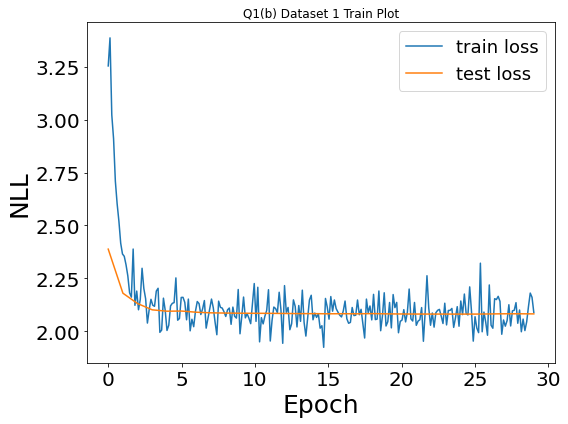

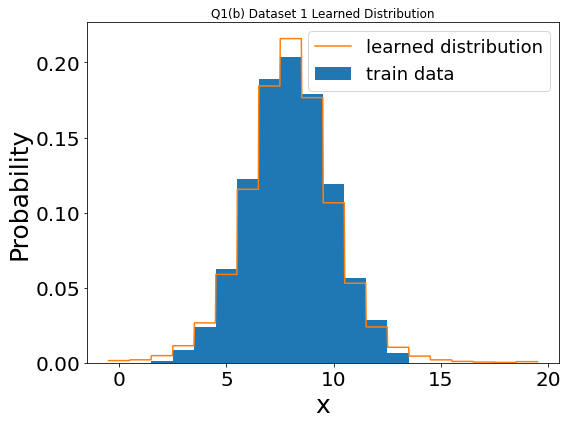

In [116]:
q1_save_results(1, 'b', q1_b)

Final Test Loss: 4.0574


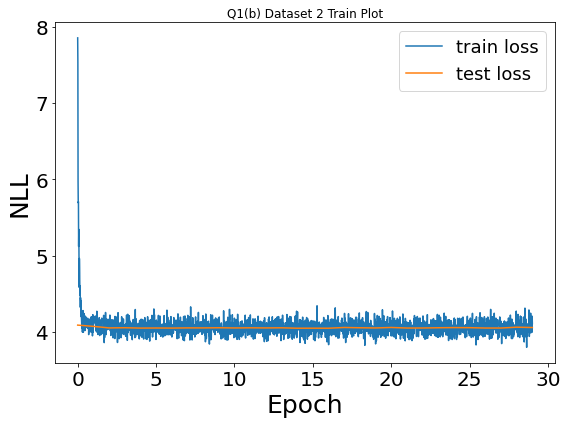

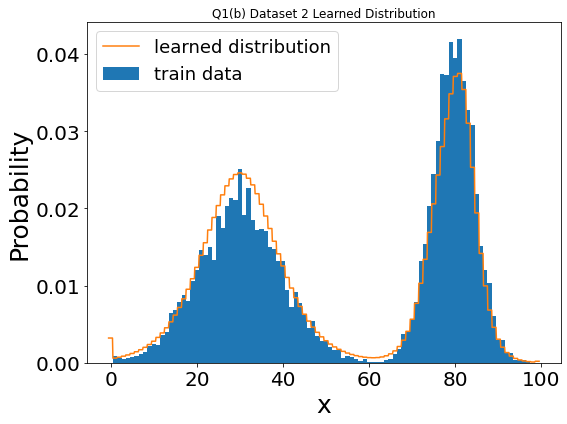

In [117]:
q1_save_results(2, 'b', q1_b)

In [90]:
def plot_distribution(data, model):

    d = model.d
    k = model.k
    plt.figure()

    priors = F.softmax(model.pi_logits, dim=0)
    plt.hist(data, bins=np.arange(d) - 0.5, label='train data', density=True)
    x = np.linspace(-0.5, d - 0.5, 1000)

    for i in range(k):   
        y = model.single_prob(i).repeat(1000 // d)
        plt.plot(x, y, label=f'prior={priors[i]:.4f}')

    plt.title('Distribution per mode')
    plt.xlabel('x')
    plt.ylabel('Probability')
    plt.legend()
    # plt.show()


In [112]:
train_data, test_data = q1_sample_data_2()

In [118]:
k = 4
model = HistogramB(d=100, k=4)
_, _ = model.fit(train_data, test_data, num_epochs=30, lr=1e-1, batch_size=100)

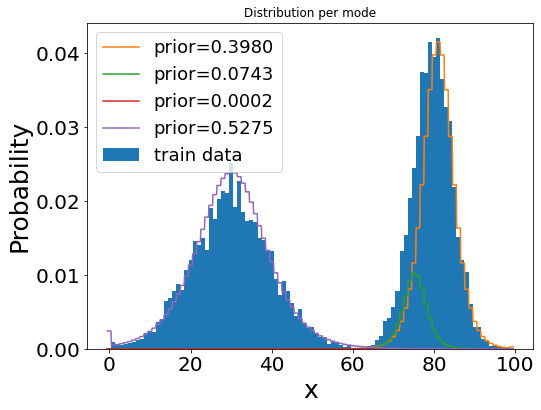

In [119]:
plot_distribution(data, model)

# Question 2: MADE

In this question, you will implement [MADE](https://arxiv.org/abs/1502.03509). In the first part, you will use MADE to model a simple 2D joint distribution, and in the second half, you will train MADE on image datasets.

## Part (a) Fitting 2D Data

First, you will work with bivariate data of the form $x = (x_0,x_1)$, where $x_0, x_1 \in \{0, \dots, d\}$. We can easily visualize a 2D dataset by plotting a 2D histogram. Run the cell below to visualize our datasets.

Dataset 1


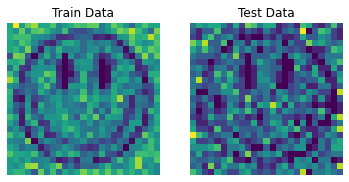

Dataset 2


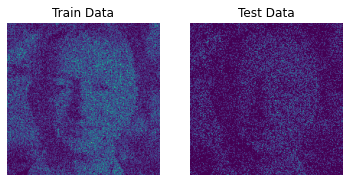

In [ ]:
visualize_q2a_data(dset_type=1)
visualize_q2a_data(dset_type=2)

Implement and train a MADE model through maximum likelihood to represent $p(x_0, x_1)$ on the given datasets, with any autoregressive ordering of your choosing. 

A few notes:
* You do not need to do training with multiple masks
* You made find it useful to one-hot encode your inputs. 

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. Visualize the learned 2D distribution by plotting a 2D heatmap


### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

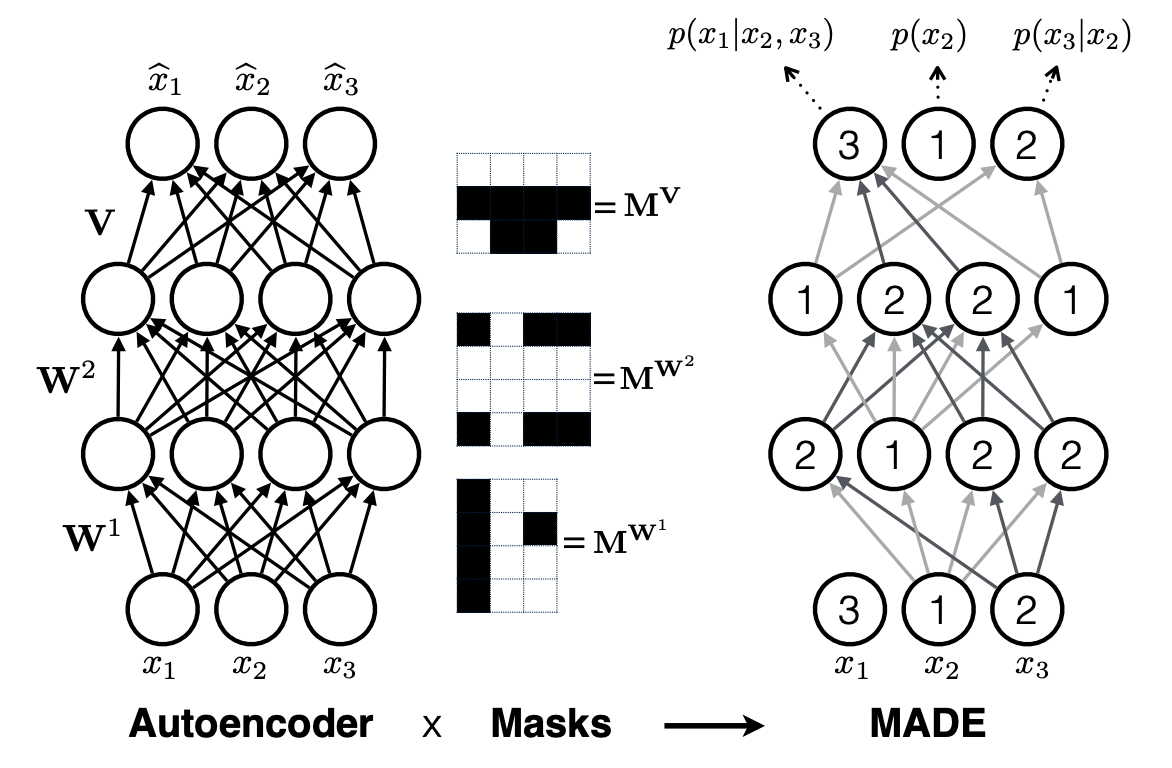

In [ ]:
class MADE(nn.Module):
    def __init__(self):
        super().__init__()
        self.m = {}
        # some init

    def make_masks(self):
        # L = num of hidden layers
        # nin = input dim
        # d = number of values per dim
                
        self.m[-1] = np.arange(nin)
        for l in range(L):
            self.m[l] = np.random.randint(self.m[l-1].min(), self.nin-1, size=hidden_size[l])
        
        masks = [self.m[l-1][:,None] <= self.m[l][None,:] for l in range(L)]
        masks.append(self.m[L-1][:,None] < self.m[-1][None,:])
        
        masks[-1] = np.repeat(masks[-1], d, axis=1)
        
        # set mask for each masked Linear layer

In [ ]:
class MaskedLinear(nn.Linear):    
    def __init__(self, in_features, out_features, bias=True):
        super().__init__(in_features, out_features, bias)        
        self.register_buffer('mask', torch.ones(out_features, in_features))
        
    def set_mask(self, mask):
        # copy mask
        
    def forward(self, input):
        return F.linear(input, self.mask * self.weight, self.bias)
        
        # self.weight = self.weight * self.mask
        # return super().forward(input)